In [ ]:
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%load_ext tensorboard
import os
import sys
import cv2
import random
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from google.colab.patches import cv2_imshow
import sklearn
from sklearn import model_selection
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
import copy
import time
import os
import glob
import pandas
import shutil

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.pytorch.transforms import ToTensor
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_path = "/content/drive/MyDrive/Hurricane_Harvey/rasters/raw"
mask_path = "/content/drive/MyDrive/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/Masks"

images=os.listdir(img_path)
img_list=[x.split('.')[0] for x in images]
print(len(img_list))
print(img_list[0])
mask = os.listdir(mask_path)
mask_list=[x.split('.')[0] for x in mask]
print(len(mask_list))
print(mask_list[0])

374
6450
299
10171


In [ ]:
d = {j:i for i,j in enumerate(img_list)}
new_list  = sorted(list((set(img_list) - set(mask_list))), key = lambda x: d[x])
train_list = list(set(img_list).intersection(mask_list))

final_list = list(f"{i}.tif" for i in new_list)
print(len(final_list))
final_train_list = list(f"{i}.tif" for i in train_list)
print(len(final_train_list))

95
279


In [ ]:
# Source and destination directories
#src_dir = '/content/drive/MyDrive/Hurricane_Harvey/rasters/raw'
#dst_dir = '/content/drive/MyDrive/Hurricane_Harvey/Processed/Images/Test_data'

# Iterate over the list of files
#for file in final_list:
    # Construct the full file path
 #   src_path = os.path.join(src_dir, file)
  #  dst_path = os.path.join(dst_dir, file)

    # Copy the file
   # shutil.copy2(src_path, dst_path)

In [ ]:
#src_dir = '/content/drive/MyDrive/Hurricane_Harvey/rasters/raw'
#dst_dir = '/content/drive/MyDrive/Hurricane_Harvey/Processed/Images/Train_data'

#for file in final_train_list:
    # Construct the full file path
 #   src_path = os.path.join(src_dir, file)
  #  dst_path = os.path.join(dst_dir, file)

    # Copy the file
   # shutil.copy2(src_path, dst_path)

In [ ]:
#src_dir = "/content/drive/MyDrive/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/Masks"
#dst_dir = "/content/drive/MyDrive/Hurricane_Harvey/Processed/masks"

#for file in mask:
    # Construct the full file path
 #   src_path = os.path.join(src_dir, file)
  #  dst_path = os.path.join(dst_dir, file)

    # Copy the file
   # shutil.copy2(src_path, dst_path)

In [ ]:
RESIZE=(512,512)
temp_root = "/content/drive/MyDrive/Hurricane_Harvey/rasters/raw" 
local_root = "/content/drive/MyDrive/DL_Assignment/DL2_Images_save"
def resize_and_save(path, resize=RESIZE, samples='all'):
  if len(os.listdir(os.path.join(local_root, path))) == 0:
    print(f"{path} --> Saving...\n")
    if samples == 'all':
      samples = len(os.listdir(os.path.join(temp_root, path)))
    for img_name in tqdm(os.listdir(os.path.join(temp_root, path))[:samples]):
      img = cv2.imread(os.path.join(temp_root, path, img_name))
      img = cv2.resize(img, RESIZE)
      cv2.imwrite(os.path.join(local_root, path, img_name), img)
  else:
    print(f"{path} --> images are already saved")

In [ ]:
resize_and_save("/content/drive/MyDrive/Hurricane_Harvey/Processed/Images/Test_data")
resize_and_save("/content/drive/MyDrive/Hurricane_Harvey/Processed/Images/Train_data")
resize_and_save("/content/drive/MyDrive/Hurricane_Harvey/Processed/masks")

/content/drive/MyDrive/Hurricane_Harvey/Processed/Images/Test_data --> images are already saved
/content/drive/MyDrive/Hurricane_Harvey/Processed/Images/Train_data --> images are already saved
/content/drive/MyDrive/Hurricane_Harvey/Processed/masks --> images are already saved


In [ ]:
train_data = "/content/drive/MyDrive/Hurricane_Harvey/Processed/Images/Train_data"
mask_data = "/content/drive/MyDrive/Hurricane_Harvey/Processed/masks"

In [ ]:
#f#_img_dir = os.path.join(train_data, "image")
#f_mask_dir = os.path.join(mask_data, "mask")

0 26
0.0 255.00000000000003


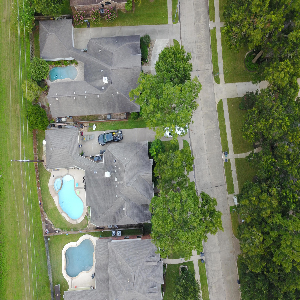

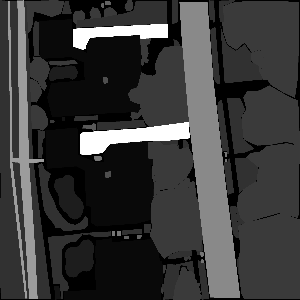

In [ ]:
sample_f_img = cv2.imread(os.path.join(train_data, sorted(os.listdir(train_data))[7]))
sample_f_mask = cv2.imread(os.path.join(mask_data, sorted(os.listdir(mask_data))[7]))

print(np.min(sample_f_mask),
np.max(sample_f_mask))

sample_f_mask = sample_f_mask * (255/26)

print(np.min(sample_f_mask),
np.max(sample_f_mask))

cv2_imshow(cv2.resize(sample_f_img, dsize=(300, 300)))
cv2_imshow(cv2.resize(sample_f_mask, dsize=(300, 300)))

In [ ]:
print(sample_f_mask.shape)

(3000, 4000, 3)


In [ ]:
kernel = np.ones((2,2),np.uint8)
cv2_imshow(cv2.erode(cv2.dilate(cv2.bilateralFilter(sample_f_img, 5, 75, 75), kernel, iterations=2), kernel, iterations=1))

In [ ]:
CLASSES = {'Background':0,'Property Roof':1,'Secondary Structure':2,'Swimming Pool':3,'Vehicle':4,'Grass':5,
         'Trees / Shrubs':6,'Solar Panels':7,'Chimney':8,'Street Light':9,'Window':10, 'Satellite Antenna':11,
         'Garbage Bins':12, 'Trampoline':13,'Road / Highway':14,'Under Construction / In Progress Status':15,
         'Power Lines & Cables':16,'Bridge':17,'Water Tank / Oil Tank':18,'Parking Area - Commercial':19,
         'Sports Complex / Arena':20,'Industrial Site':21,'Dense Vegetation / Forest':22,
         'Water Body':23,'Flooded':24,'Boat':25,'Parking Area':26}
IMG_DIM= 512
NB_CLASSES = len(CLASSES)

In [ ]:
# CONFIG
TENSORBOARD_DIR = "/content/drive/MyDrive/Hurricane_Harvey/runs/"
MODEL_DIR = "/content/drive/MyDrive/Hurricane_Harvey/models/"
#UNLABELLED_SPLIT = 100 # first 100 unlabelled examples will be used
## RAM storage error
os.makedirs(TENSORBOARD_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [ ]:
# Train Data Augmentation (Image and Masks)
from albumentations import RandomRotate90, HorizontalFlip, VerticalFlip, Transpose, Rotate

augmentation = A.Compose([
    A.RandomRotate90(p=1),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
])

for image in os.listdir(train_data):
  im = cv2.imread(train_data+"/"+image)
  msk = cv2.imread(mask_data+"/"+image.split(".")[0]+".png")
  for i in range(1,6):
    res_augmentation = augmentation(image=im, mask=msk)

(3000, 4000, 3)
(3000, 4000, 3)
(3000, 4000, 3)
(3000, 4000, 3)
(3072, 4592, 3)
(3000, 4000, 3)
(3000, 4000, 3)
(3000, 4000, 3)


KeyboardInterrupt: ignored

In [ ]:
class SegDataset:
    def __init__(self, x_paths, trans1,trans2, img_dim, unlabelled=False):
        self.x_paths = x_paths
        self.unlabelled = unlabelled
        if not self.unlabelled:
          #self.y_paths = [x.replace("image", "mask").replace(".tif", ".png") for x in self.x_paths]
          self.y_paths = ["/content/drive/MyDrive/Hurricane_Harvey/Processed/masks/"+x.split("/")[-1].replace(".tif",".png") for x in self.x_paths]
        else:
          self.y_paths = None
        self.img_dim = img_dim
        self.trans1=trans1
        self.trans2=trans2

    def __len__(self):
      return len(self.x_paths)
    
    def get_newMask(self, mask, classes, dim=IMG_DIM):
      mask = torch.as_tensor(mask[:,:,0], dtype=torch.int64)
      return torch.moveaxis(torch.nn.functional.one_hot(mask, num_classes=len(classes)), -1, 0).numpy()

    def __getitem__(self, index):
      image = cv2.imread(self.x_paths[index])
      #print("image size gettiem : ",image.shape)

      kernel = np.ones((2,2),np.uint8)
      image = cv2.bilateralFilter(image, 5, 75, 75)
      image = cv2.erode(cv2.dilate(image, kernel, iterations=2), kernel, iterations=1)
      #print("image size after dilate : ",image.shape)
      if not self.unlabelled:
        mask = cv2.imread(self.y_paths[index])
        #print("mask size imread : ",mask.shape)
      else:
        mask = np.random.rand(512, 512, 3)
      if self.trans1:
        transformed1 = self.trans1(image=image, mask=mask)
        image = transformed1["image"]
        #print("image size after transformed1 : ",image.shape)
        mask = self.get_newMask(transformed1["mask"],CLASSES)
        #print("mask size get_newMask : ",mask.shape)
      if self.trans2:
        transformed2 = self.trans2(image=image, mask=mask)
        image = transformed2["image"]
        #print("image size after transformed2 : ",image.shape)
      return image, mask

In [ ]:
x = [os.path.join(train_data, file) for file in sorted(os.listdir(train_data))]

x_train, x_test = model_selection.train_test_split(x, test_size=0.2, shuffle=True)

train_transform1 = A.Compose([
        A.Resize(IMG_DIM, IMG_DIM),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        # A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

train_transform2=A.Compose([ToTensorV2()])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
training_set = SegDataset(x_train,  train_transform1, train_transform2, img_dim=IMG_DIM)
testing_set = SegDataset(x_test, train_transform1,train_transform2, img_dim=IMG_DIM)
image_datasets = {'train': training_set, 'valid': testing_set}

In [ ]:
len(training_set)

239

In [ ]:
train_dataloader = torch.utils.data.DataLoader(training_set, batch_size=3, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(testing_set, batch_size=3, num_workers=0)

In [ ]:
#UNet architecture with pre-trained ResNet18 Encoder
#Based on https://github.com/usuyama/pytorch-unet

def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

In [ ]:
#Define model
model = ResNetUNet(NB_CLASSES)

#Define loss criterion
criterion = nn.CrossEntropyLoss()

#Specify number of epochs
epochs = 5

#Check hardware and enable CUDA if preferred, otherwise uses CPU.
enable_cuda = True

if torch.cuda.is_available() & enable_cuda:
    model = model.cuda()
    criterion = nn.CrossEntropyLoss().cuda()
    device = torch.device("cuda")
    print("CUDA enabled, using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

#Define optimizer (should be defined after CUDA is activated)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#Define save location for model progress etc.
save_folder="/content/drive/MyDrive/Hurricane_Harvey/models/"

#Function for saving accuracy and loss
def write_results(save_folder, epoch, train_loss, val_loss):
    ff=open('./{}/progress.txt'.format("./"),'a')
    ff.write(' E: ')
    ff.write(str(epoch))
    ff.write('         ')
    ff.write(' TRAIN_LOSS: ')
    ff.write(str('%.3f' % train_loss))
    ff.write(' VAL_LOSS: ')
    ff.write(str('%.3f' % val_loss))
    ff.write('\n')

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CUDA enabled, using GPU


In [ ]:
torch.cuda.empty_cache()

  0%|          | 0/80 [00:00<?, ?it/s]

Train (epoch 1/5) [0/80 (0%)]	Loss: 3.267036


  0%|          | 0/20 [00:00<?, ?it/s]

TRAIN_LOSS:  2.213
VAL_LOSS:  1.910


  0%|          | 0/80 [00:00<?, ?it/s]

Train (epoch 2/5) [0/80 (0%)]	Loss: 1.891309


  0%|          | 0/20 [00:00<?, ?it/s]

TRAIN_LOSS:  1.849
VAL_LOSS:  1.679


  0%|          | 0/80 [00:00<?, ?it/s]

Train (epoch 3/5) [0/80 (0%)]	Loss: 1.658410


  0%|          | 0/20 [00:00<?, ?it/s]

TRAIN_LOSS:  1.539
VAL_LOSS:  1.435


  0%|          | 0/80 [00:00<?, ?it/s]

Train (epoch 4/5) [0/80 (0%)]	Loss: 1.403871


  0%|          | 0/20 [00:00<?, ?it/s]

TRAIN_LOSS:  1.277
VAL_LOSS:  1.246


  0%|          | 0/80 [00:00<?, ?it/s]

Train (epoch 5/5) [0/80 (0%)]	Loss: 1.342762


  0%|          | 0/20 [00:00<?, ?it/s]

TRAIN_LOSS:  1.171
VAL_LOSS:  1.263


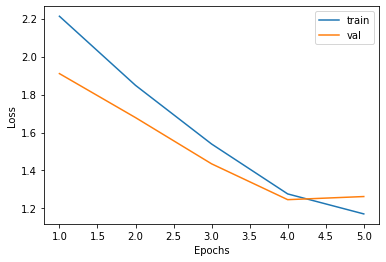

In [ ]:
total_train_losses = []
total_val_losses = []

for epoch in range(1,epochs+1):
    
    #Training
    model.train()
    train_losses = []

    #Iterate through training batches
    for i, batch, in enumerate(tqdm(train_dataloader)):
        img_batch, lbl_batch = batch

        #Transfer images and masks to GPU
        img_batch = img_batch.to(device)
        lbl_batch = lbl_batch.to(device)
        
        optimizer.zero_grad()

        #Compute output
        outputs = model(img_batch.float())

        #Compute loss
        #loss=criterion(outputs, lbl_batch.long())
        loss=criterion(outputs, lbl_batch.float())
        
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if i % 500 == 0:
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, epochs, i, len(train_dataloader),100.*i/len(train_dataloader), loss.item()))

    train_loss_mean = np.mean(train_losses)
    total_train_losses.append(train_loss_mean)

    #Validation
    model.eval()
    val_losses = []

    #Iterate through validation batches
    for i, batch, in enumerate(tqdm(val_dataloader)):
        img_batch, lbl_batch = batch

        #Transfer images and masks to GPU
        img_batch = img_batch.to(device)
        lbl_batch = lbl_batch.to(device)

        #Compute output
        outputs=model(img_batch.float())

        #Compute loss
        loss=criterion(outputs, lbl_batch.float())

        val_losses.append(loss.item())

    val_loss_mean = np.mean(val_losses)
    total_val_losses.append(val_loss_mean)

    print('TRAIN_LOSS: ', '%.3f' % train_loss_mean)
    print('VAL_LOSS: ', '%.3f' % val_loss_mean)

    write_results(save_folder, epoch, train_loss_mean, val_loss_mean)

    #Save model
    torch.save(model.state_dict(), save_folder + 'model.pt'.format(epoch))

#Plot graph
plt.plot(list(range(epochs+1))[1:], total_train_losses)
plt.plot(list(range(epochs+1))[1:], total_val_losses)
plt.legend(['train', 'val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

**EVALUATION ON TEST DATA**

In [ ]:
MODEL_LOAD_PATH = f'/content/drive/MyDrive/Hurricane_Harvey/models/model.pt'
DIR_PATH = f'/content/drive/MyDrive/Hurricane_Harvey/Processed/Images/Test_data'
SAVE_PATH = f'/content/drive/MyDrive/Hurricane_Harvey/predictions'

os.makedirs(SAVE_PATH, exist_ok=True)

LOAD_SIZE = 3 # pred generating load size

In [ ]:
model = ResNetUNet(NB_CLASSES)
model = model.to(device)
model.load_state_dict(torch.load(MODEL_LOAD_PATH))
# model.eval()

<All keys matched successfully>

In [ ]:
all_images=sorted(os.listdir(DIR_PATH))
all_masks=[x.replace(".tif", ".png") for x in all_images]

image_paths=[os.path.join(DIR_PATH, file) for file in sorted(os.listdir(DIR_PATH))]
mask_paths=[os.path.join(SAVE_PATH, file) for file in all_masks]
print(len(image_paths))
print(mask_paths)

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

75
['/content/drive/MyDrive/Hurricane_Harvey/predictions/10184.png', '/content/drive/MyDrive/Hurricane_Harvey/predictions/10300.png', '/content/drive/MyDrive/Hurricane_Harvey/predictions/6414.png', '/content/drive/MyDrive/Hurricane_Harvey/predictions/6427.png', '/content/drive/MyDrive/Hurricane_Harvey/predictions/6447.png', '/content/drive/MyDrive/Hurricane_Harvey/predictions/6456.png', '/content/drive/MyDrive/Hurricane_Harvey/predictions/6469.png', '/content/drive/MyDrive/Hurricane_Harvey/predictions/6499.png', '/content/drive/MyDrive/Hurricane_Harvey/predictions/6548.png', '/content/drive/MyDrive/Hurricane_Harvey/predictions/6569.png', '/content/drive/MyDrive/Hurricane_Harvey/predictions/6574.png', '/content/drive/MyDrive/Hurricane_Harvey/predictions/6580.png', '/content/drive/MyDrive/Hurricane_Harvey/predictions/6603.png', '/content/drive/MyDrive/Hurricane_Harvey/predictions/6608.png', '/content/drive/MyDrive/Hurricane_Harvey/predictions/6639.png', '/content/drive/MyDrive/Hurricane_

In [ ]:
def reverse_transform_mask(inp):
    inp=inp.transpose((1, 2, 0))
    t_mask=np.argmax(inp,axis=2).astype('float32') 
    t_mask=cv2.resize(t_mask, dsize=(4000, 3000))
    kernel = np.ones((3,3),np.uint8)
    t_mask = cv2.erode(t_mask, kernel, iterations=1)
    return t_mask

In [ ]:
class ValDataset:
    def __init__(self, img_paths, val_trans, img_dim):
        self.img_paths = img_paths
        self.img_dim = img_dim
        self.val_trans=val_trans

    def __len__(self):
      return len(self.img_paths)

    def __getitem__(self, index):
      image = cv2.resize(cv2.imread(self.img_paths[index]), dsize=(self.img_dim, self.img_dim))
      
      kernel = np.ones((2,2),np.uint8)
      image = cv2.bilateralFilter(image, 5, 75, 75)
      image = cv2.erode(cv2.dilate(image, kernel, iterations=2), kernel, iterations=1)
      
      if self.val_trans:
        image=self.val_trans(image)
      return image, index

In [ ]:
val_set = ValDataset(image_paths, val_transform , img_dim=IMG_DIM)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=LOAD_SIZE, shuffle=False)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model.eval()

for inputs, index in tqdm(val_dataloader):
  inputs = inputs.to("cuda")
  with torch.no_grad():
    preds = model(inputs)
    preds = torch.sigmoid(preds)
    preds = preds.data.cpu().numpy()
  for i in range(LOAD_SIZE):
    f_mask=reverse_transform_mask(preds[i])
    cv2.imwrite(mask_paths[index[i]],f_mask)

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
# resize masks with original image size$
#print(mask_paths)
for file in mask_paths:
  mask = cv2.imread(file)
  id_tif = file.split("/")[-1].replace(".png",".tif")
  image = cv2.imread(DIR_PATH+"/"+id_tif)
  mask_resize = cv2.resize(mask, (image.shape[1],image.shape[0]))
  #print(mask_resize.shape)
  mask_resize_gray = cv2.cvtColor(mask_resize, cv2.COLOR_BGR2GRAY)
  #print(mask_resize_gray.shape)
  cv2.imwrite(file,mask_resize_gray)

(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3072, 4592, 3)
(3072, 4592)
(3072, 4592, 3)
(3072, 4592)
(3072, 4592, 3)
(3072, 4592)
(3072, 4592, 3)
(3072, 4592)
(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3072, 4592, 3)
(3072, 4592)
(3000, 4000, 3)
(3000, 4000)
(3072, 4592, 3)
(3072, 4592)
(3072, 4592, 3)
(3072, 4592)
(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3000, 4000, 3)
(3000, 4000)
(3072, 4592, 3)
(3072, 4592)
(3072, 4592, 3)
(3072, 4592)
(3072, 4592, 3)
(3072, 4592)
(3072, 4592, 3)
(3072, 4592)
(3000, 4000, 3

(3072, 4592)
(3072, 4592, 3)


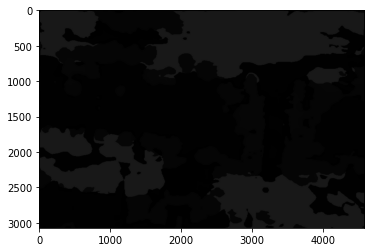

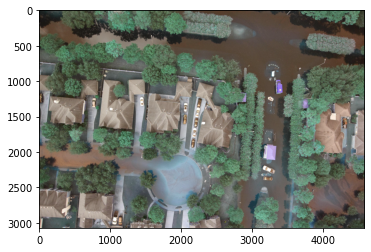

In [ ]:
id = 7596
plt.figure()
plt.imshow(cv2.imread(f'/content/drive/MyDrive/Hurricane_Harvey/predictions/{id}.png'))
print(cv2.imread(f'/content/drive/MyDrive/Hurricane_Harvey/predictions/{id}.png',cv2.IMREAD_UNCHANGED).shape)
plt.figure()
plt.imshow(cv2.imread(f'/content/drive/MyDrive/Hurricane_Harvey/Processed/Images/Test_data/{id}.tif'))
print(cv2.imread(f'/content/drive/MyDrive/Hurricane_Harvey/Processed/Images/Test_data/{id}.tif',cv2.IMREAD_UNCHANGED).shape)

In [ ]:
import tarfile  

tar = tarfile.open("submission.tar", "w")  
for root, dir, files in os.walk('/content/drive/MyDrive/Hurricane_Harvey/predictions/'):
	for  file in files:
		fullpath = os.path.join(root, file)
		tar.add(fullpath, arcname=file)

tar.close()

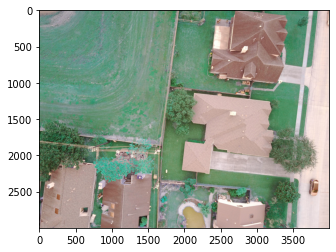

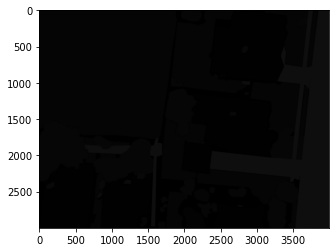

In [ ]:
# TEST DATA AUGMENTATION
from albumentations import RandomRotate90, HorizontalFlip, VerticalFlip, Transpose, Rotate

img_test = cv2.imread('/content/drive/MyDrive/Hurricane_Harvey/Processed/Images/Train_data/6412.tif')
mask_test = cv2.imread('/content/drive/MyDrive/Hurricane_Harvey/Processed/masks/6412.png')
plt.imshow(img_test)
plt.figure()
plt.imshow(mask_test)

In [ ]:
augmentation = A.Compose([
    A.RandomRotate90(p=1),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
])

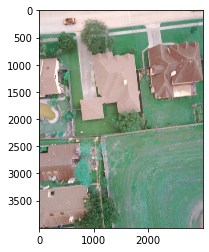

In [ ]:
res_augmentation = augmentation(image=img_test)["image"]
plt.imshow(res_augmentation)